# Homework 3 Python Programming

Last updated: Oct 3, 2025

## Learning Objectives
In this assignment, you will:
1. **Part 1**: Implement bagging ensemble methods and cross-validation techniques
2. **Part 2**: Build a Perceptron classifier from scratch and understand linear classification
3. **Part 3**: Transition from single-layer Perceptron to multi-layer neural networks (MLP), implement custom backpropagation, and train on non-linearly separable datasets

Please answer all questions in this notebook (you will see comments like "# YOUR CODE HERE" and "# END YOUR CODE").


## Setup

**IMPORTANT**: Before you edit this notebook, you will need to make your own copy (otherwise your edits **will not be saved**).  You can do so by clicking the "File" dropdown in the upper left, and then selecting "Save a copy in Drive" as shown in the screenshot below.

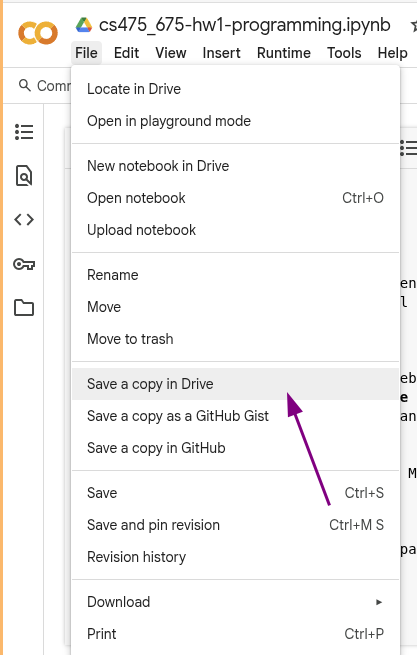

## [Optional] Recommended step

This is completely optional, as the free version of Colab should be more than enough for assignments in this class.

Google is offering a free 1-year Colab Pro trial for college students and researchers! We recommend that you sign up for it so that you can get better GPU resources for:

- Assignments involving neural networks
- Course projects (not necessarily for this class) that require a GPU for acceleration

Link: https://colab.research.google.com/signup

(Also, you might want to make a reminder to cancel it a few days before renewal)





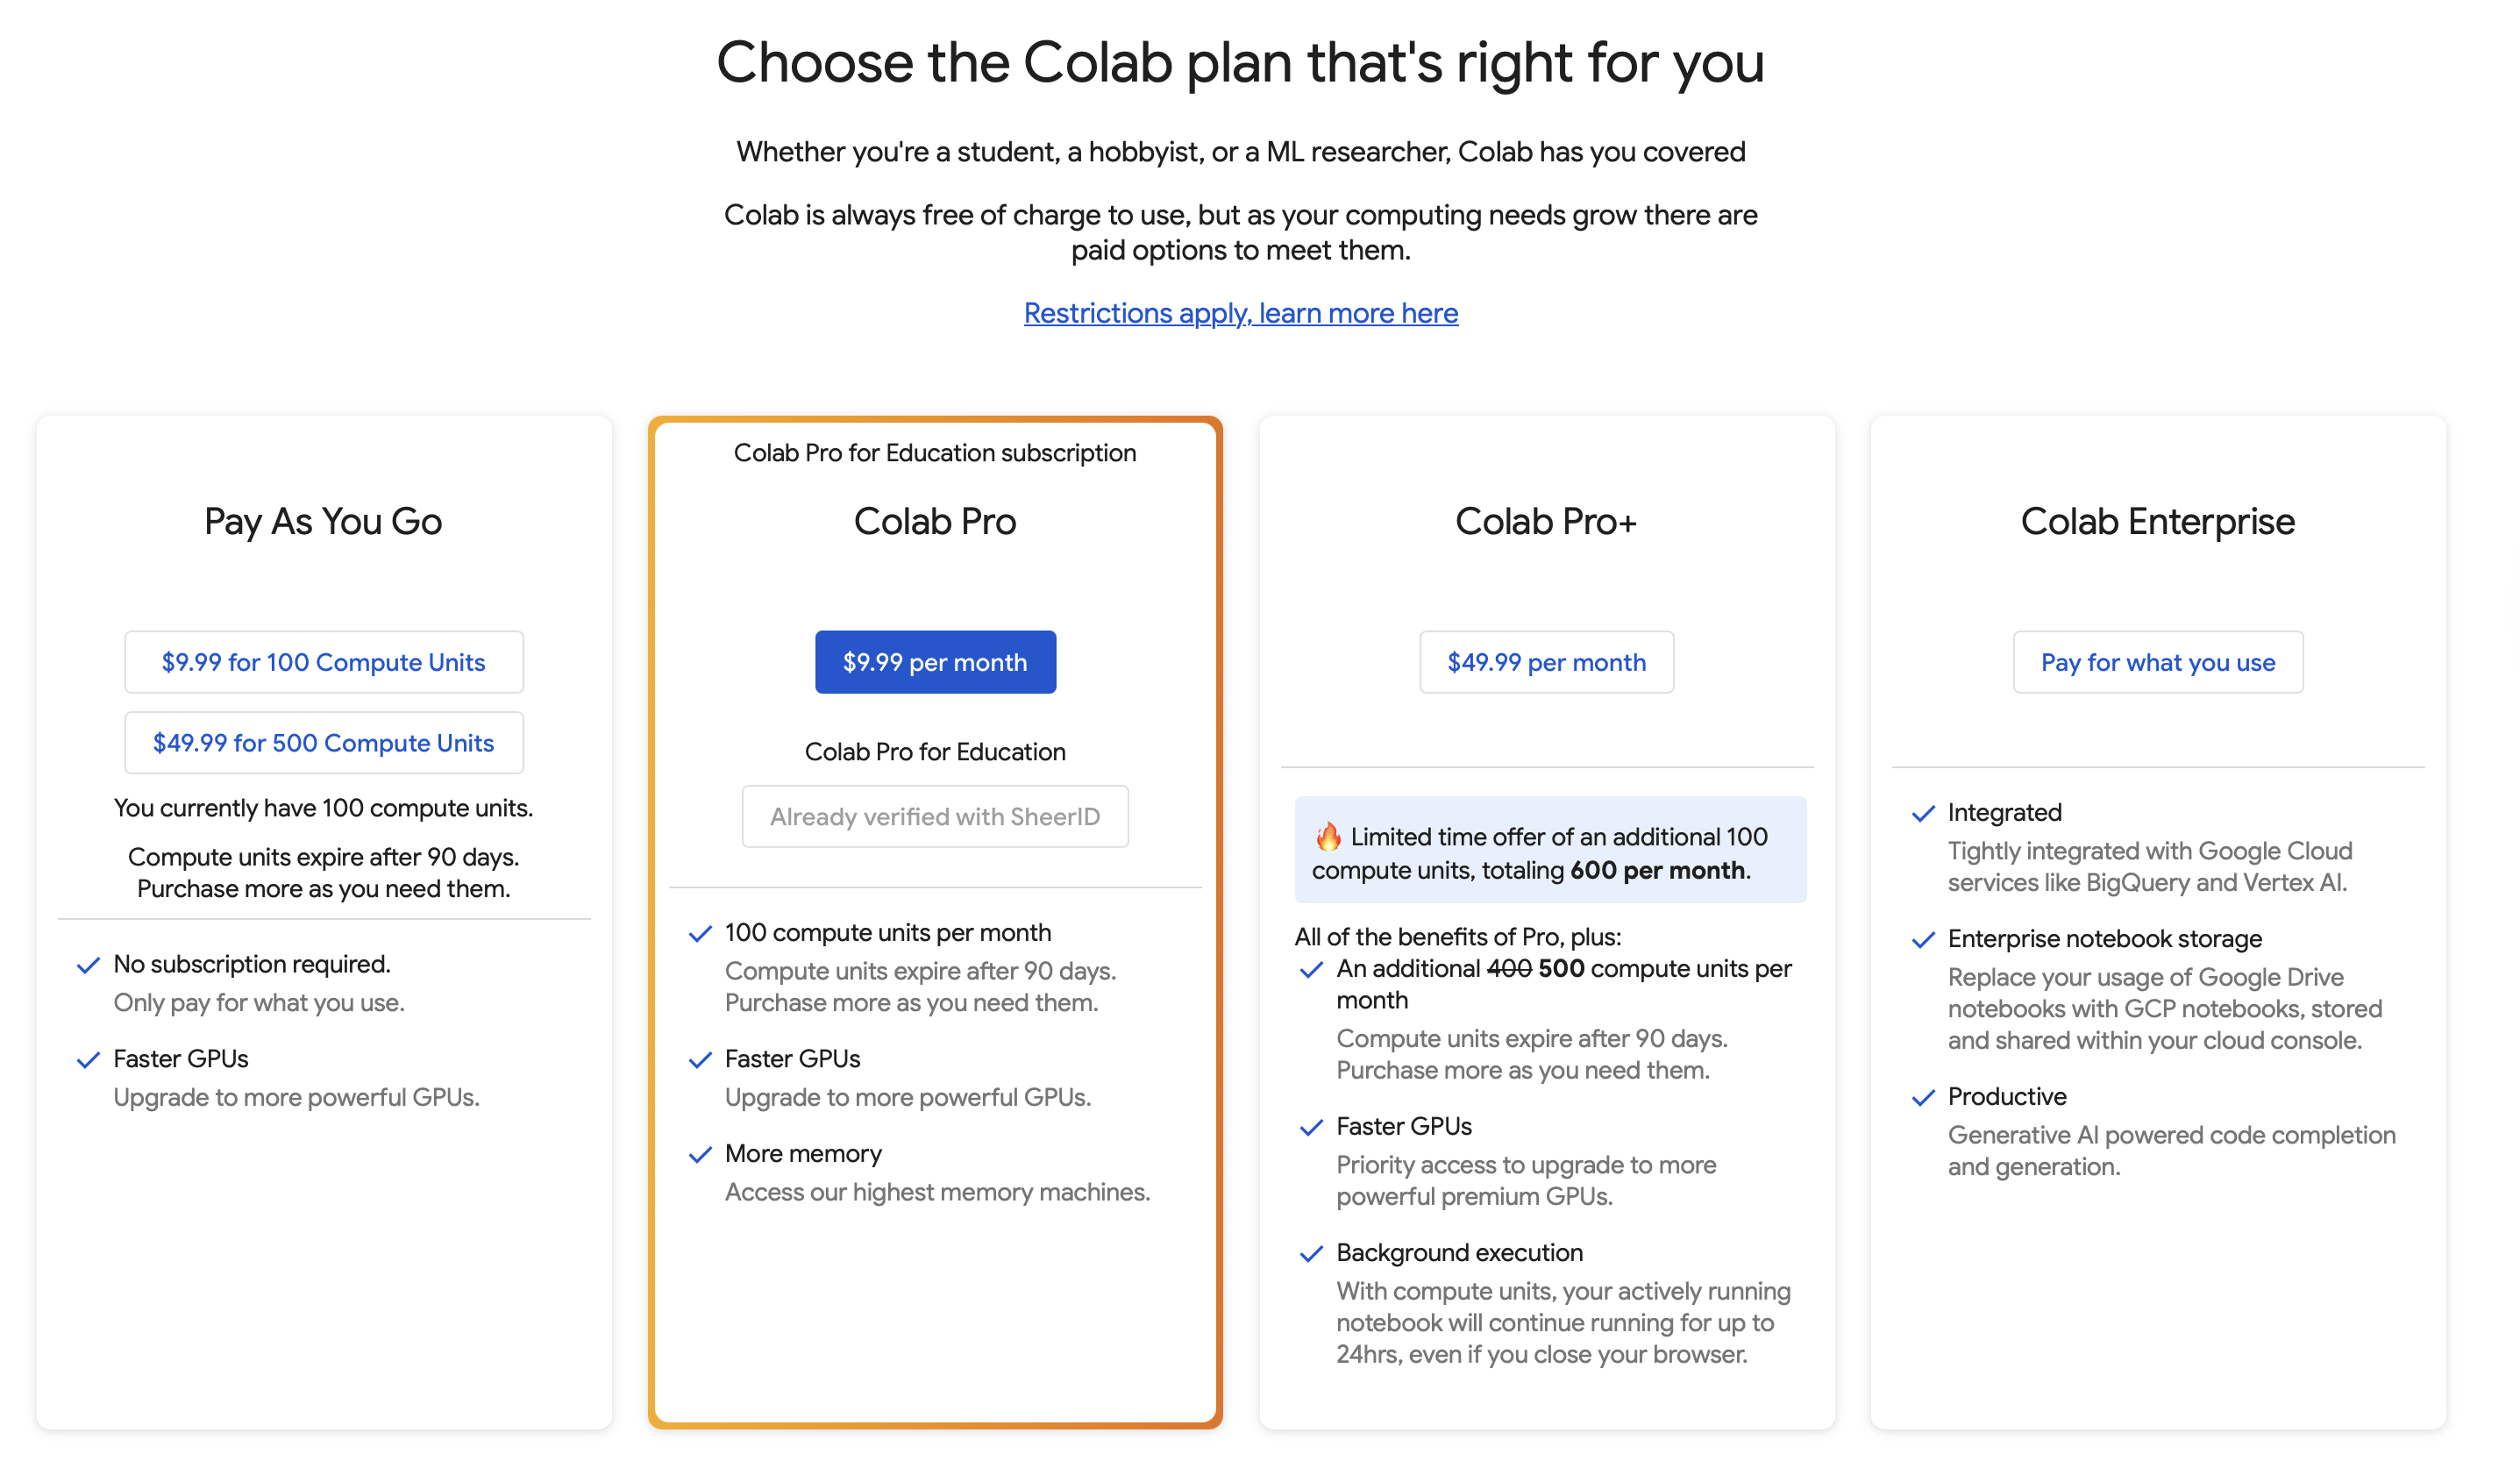

In [ ]:
# Install required packages
%pip install -q numpy pandas matplotlib scikit-learn datasets tqdm torch ipywidgets

## Student Information
**IMPORTANT**: Fill in your information in the cell below before starting the assignment.

In [ ]:
# IMPORTANT: This cell contains metadata for grading. Do not delete this cell.
# STUDENT INFORMATION - REQUIRED
# Fill in your information below

JHED_ID = "ralduli1"  # Your JHED ID (e.g., "zhuang86" - the part before @jhu.edu)
COLAB_LINK = "https://colab.research.google.com/drive/1A7cKGwEfmyDQOwiQmU8mFtj0l316S_n-?usp=sharing"  # Public sharing link to this Colab notebook
                  # To get this: "Share" on upper right corner -> "Copy link" (make sure it's set to "Anyone with the link")

# Verify your information is entered
assert JHED_ID != "", "Please enter your JHED ID"
assert COLAB_LINK != "", "Please enter your Colab sharing link"
assert "colab.research.google.com" in COLAB_LINK or COLAB_LINK == "LOCAL", "Please enter a valid Colab link or 'LOCAL' if testing locally"

print(f"JHED ID: {JHED_ID}")
print(f"Colab Link: {COLAB_LINK}")

In [ ]:
# Setup and imports
import math
from typing import Any, Callable, Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from numpy.typing import NDArray
from sklearn.datasets import (load_breast_cancer, make_circles,
                              make_classification, make_moons)
from sklearn.linear_model import Perceptron as SkPerceptron
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from torch import nn
from torch.autograd import Function

## Part 1: Bagging and Cross Validation

In this section, you will implement and evaluate a bagging ensemble and estimate generalization using stratified k-fold cross-validation. Let's first load the dataset.


In [ ]:
breast = load_breast_cancer()
X_bag = breast.data.astype(np.float64)
y_bag = breast.target.astype(np.int32)

X_bag_train, X_bag_test, y_bag_train, y_bag_test = train_test_split(
    X_bag,
    y_bag,
    test_size=0.3,
    random_state=42,
    stratify=y_bag,
)

print(f"Training samples: {X_bag_train.shape[0]}, features: {X_bag_train.shape[1]}")
print(f"Test samples: {X_bag_test.shape[0]}")
pd.DataFrame(X_bag_train, columns=breast.feature_names).head(3)


### 1.1 Bagging Ensemble Methods *(autograded)*

We will build a bagging classifier that aggregates an ensemble of decision trees on a multi-class dataset.


In [ ]:
# IMPORTANT: This cell contains metadata for grading.
# Everything in this cell will be used by the autograder.
# Do not delete this cell.


class BaggingEnsemble:
    """Bagging ensemble for classification tasks.

    Attributes:
        base_estimator_factory: Callable that returns a fresh estimator given a random seed.
        n_estimators: Number of base estimators to train.
        max_samples: Number (or fraction) of samples to draw for each bootstrap replicate.
        bootstrap: Whether to sample with replacement.
        random_state: Seed controlling bootstrap sampling.
        estimators_: List of fitted estimators.
        sample_indices_: Bootstrap indices used for each estimator.
        classes_: Sorted unique class labels observed during training.
    """

    def __init__(
        self,
        base_estimator_factory: Callable[[int], Any],
        n_estimators: int = 25,
        max_samples: float | int = 1.0,
        bootstrap: bool = True,
        random_state: Optional[int] = None,
    ) -> None:
        self.base_estimator_factory = base_estimator_factory
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.bootstrap = bootstrap
        self.random_state = random_state
        self.estimators_: List[Any] = []
        self.sample_indices_: List[NDArray[np.int32]] = []
        self.classes_: Optional[NDArray] = None

    def _resolve_sample_size(self, n_samples: int) -> int:
        if isinstance(self.max_samples, float):
            if not 0 < self.max_samples <= 1:
                raise ValueError("max_samples as a fraction must lie in (0, 1].")
            size = int(np.ceil(self.max_samples * n_samples))
        else:
            size = int(self.max_samples)
        if size <= 0:
            raise ValueError("max_samples must be positive.")
        if size > n_samples:
            raise ValueError("max_samples cannot exceed the number of samples.")
        return size

    def fit(self, X: NDArray[np.float64], y: NDArray) -> "BaggingEnsemble":
        if X.shape[0] != y.shape[0]:
            raise ValueError("X and y must have the same number of samples.")
        if self.n_estimators <= 0:
            raise ValueError("n_estimators must be a positive integer.")

        rng = np.random.default_rng(self.random_state)
        n_samples = X.shape[0]
        sample_size = self._resolve_sample_size(n_samples)
        self.estimators_ = []
        self.sample_indices_ = []
        self.classes_ = np.unique(y)

        for _ in range(self.n_estimators):
            indices = rng.choice(n_samples, size=sample_size, replace=self.bootstrap)
            estimator_seed = int(rng.integers(0, np.iinfo(np.int32).max))
            estimator = self.base_estimator_factory(estimator_seed)
            estimator.fit(X[indices], y[indices])
            self.estimators_.append(estimator)
            self.sample_indices_.append(indices.astype(np.int32))

        return self

    def predict(self, X: NDArray[np.float64]) -> NDArray[np.int32]:
        if not self.estimators_:
            raise ValueError("Fit the ensemble before calling predict.")

        majority_votes = []

        # YOUR CODE HERE
        ...
        # END YOUR CODE
        return np.array(majority_votes, dtype=np.int32)

    def predict_proba(self, X: NDArray[np.float64]) -> NDArray[np.float64]:
        if not self.estimators_:
            raise ValueError("Fit the ensemble before calling predict_proba.")
        probas = []
        for est in self.estimators_:
            if not hasattr(est, "predict_proba"):
                raise AttributeError("Base estimator must support predict_proba for probability predictions.")
            probas.append(est.predict_proba(X))
        return np.mean(probas, axis=0)


We compare the bagging ensemble against a single depth-3 decision tree baseline on the held-out test set.

In [ ]:
def tree_factory(seed):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("tree", DecisionTreeClassifier(max_depth=3, random_state=seed)),
    ])

bagging_model = BaggingEnsemble(
    base_estimator_factory=tree_factory,
    n_estimators=40,
    max_samples=1.0,
    bootstrap=True,
    random_state=42,
)
bagging_model.fit(X_bag_train, y_bag_train)

bag_train_pred = bagging_model.predict(X_bag_train)
bag_test_pred = bagging_model.predict(X_bag_test)

single_tree = tree_factory(0)
single_tree.fit(X_bag_train, y_bag_train)

tree_train_pred = single_tree.predict(X_bag_train)
tree_test_pred = single_tree.predict(X_bag_test)

bag_train_accuracy = accuracy_score(y_bag_train, bag_train_pred)
bag_test_accuracy = accuracy_score(y_bag_test, bag_test_pred)

tree_train_accuracy = accuracy_score(y_bag_train, tree_train_pred)
tree_test_accuracy = accuracy_score(y_bag_test, tree_test_pred)


ensemble_comparison = pd.DataFrame(
    [
        {
            "model": "Bagging (40 x depth-3 tree)",
            "train_accuracy": bag_train_accuracy,
            "test_accuracy": bag_test_accuracy,
        },
        {
            "model": "Depth-3 decision tree",
            "train_accuracy": tree_train_accuracy,
            "test_accuracy": tree_test_accuracy,
        },
    ]
)
ensemble_comparison

### 1.2 Cross Validation *(autograded)*

We now estimate generalization performance using stratified k-fold cross-validation.


Complete the helper function `evaluate_with_stratified_kfold` in the next cell.


In [ ]:
# IMPORTANT: This cell contains metadata for grading.
# Everything in this cell will be used by the autograder.
# Do not delete this cell.


def evaluate_with_stratified_kfold(
    X: NDArray[np.float64],
    y: NDArray,
    model_factory: Callable[[int], Any],
    n_splits: int = 5,
    scoring: Callable[[NDArray, NDArray], float] = accuracy_score,
    random_state: Optional[int] = None,
) -> Dict[str, Any]:
    """Perform stratified k-fold cross validation and report scores."""
    if n_splits < 2:
        raise ValueError("n_splits must be at least 2.")

    X = np.asarray(X)
    y = np.asarray(y)

    # We shuffle the data before splitting to ensure that the folds are representative of the overall distribution.
    # Then, we use StratifiedKFold to split the data into n_splits folds.
    splitter = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # rng is used to generate random seeds for the models
    rng = np.random.default_rng(random_state)

    train_scores: List[float] = []
    validation_scores: List[float] = []

    for train_indices, val_indices in splitter.split(X, y):
        model_seed = int(rng.integers(0, np.iinfo(np.int32).max))
        model = model_factory(model_seed)

        # YOUR CODE HERE
        # Get the training and validation folds
        X_train_fold = X[...]
        y_train_fold = y[...]
        X_val_fold = X[...]
        y_val_fold = y[...]

        # Fit the model
        ...

        # Predict on the training and validation folds
        train_pred = ...
        val_pred = ...

        # Compute the scores
        train_scores.append(...)
        validation_scores.append(...)
        # END YOUR CODE
    mean_validation = float(np.mean(validation_scores))

    return {
        "train_scores": train_scores,
        "validation_scores": validation_scores,
        "mean_validation_score": mean_validation,
    }


In [ ]:
bagging_cv_results = evaluate_with_stratified_kfold(
    X_bag,
    y_bag,
    model_factory=lambda seed: BaggingEnsemble(
        base_estimator_factory=lambda tree_seed: DecisionTreeClassifier(max_depth=3, random_state=tree_seed),
        n_estimators=40,
        max_samples=1.0,
        bootstrap=True,
        random_state=seed,
    ),
    n_splits=5,
    scoring=accuracy_score,
    random_state=42,
)

tree_cv_results = evaluate_with_stratified_kfold(
    X_bag,
    y_bag,
    model_factory=lambda seed: DecisionTreeClassifier(max_depth=3, random_state=seed),
    n_splits=5,
    scoring=accuracy_score,
    random_state=42,
)

cv_summary = pd.DataFrame(
    [
        {
            "model": "Bagging (40 x depth-3 tree)",
            "mean_train_accuracy": np.mean(bagging_cv_results["train_scores"]),
            "mean_val_accuracy": bagging_cv_results["mean_validation_score"],
        },
        {
            "model": "Depth-3 decision tree",
            "mean_train_accuracy": np.mean(tree_cv_results["train_scores"]),
            "mean_val_accuracy": tree_cv_results["mean_validation_score"],
        },
    ]
)

print("Bagging train scores:", bagging_cv_results["train_scores"])
print("Decision tree train scores:", tree_cv_results["train_scores"])
print("Bagging validation scores:", bagging_cv_results["validation_scores"])
print("Decision tree validation scores:", tree_cv_results["validation_scores"])
cv_summary


You should be able to see that our bagging classifier performs better here, with higher accuracy, smaller overfitting, and good stability.

## Part 2: Perceptron

In this part, we will implement the Perceptron algorithm and run it on a synthetic binary classification task generated with `make_classification`. The features are standardized so they are on comparable scales. Because the dataset is only moderately separable, the order in which examples are presented across epochs has a noticeable effect on convergence and generalization.


In [ ]:
# Dataset 1: Linearly Separable
print("=" * 60)
print("Dataset 1: Linearly Separable")
print("=" * 60)

X_perc_sep_raw, y_perc_sep_raw = make_classification(
    n_samples=400,
    n_features=100,
    n_informative=80,
    n_redundant=2,
    n_clusters_per_class=1,
    class_sep=1,
    flip_y=0.0,
    random_state=1,
)

y_perc_sep = np.where(y_perc_sep_raw == 1, 1, -1).astype(np.int32)

X_sep_train, X_sep_test, y_sep_train, y_sep_test = train_test_split(
    X_perc_sep_raw,
    y_perc_sep,
    test_size=0.2,
    random_state=42,
    stratify=y_perc_sep,
)

scaler_sep = StandardScaler()
X_sep_train = scaler_sep.fit_transform(X_sep_train)
X_sep_test = scaler_sep.transform(X_sep_test)

print(f"Training samples: {X_sep_train.shape[0]}, features: {X_sep_train.shape[1]}")
print(f"Test samples: {X_sep_test.shape[0]}")

# Dataset 2: Non-Linearly Separable (with label noise)
print("\n" + "=" * 60)
print("Dataset 2: Non-Linearly Separable (with label noise)")
print("=" * 60)

X_perc_nonsep_raw, y_perc_nonsep_raw = make_classification(
    n_samples=400, n_features=100,
    n_informative=90,
    n_classes=2, n_clusters_per_class=1,
    class_sep=0.7, flip_y=0.10,
    shuffle=True, random_state=1,
)

y_perc_nonsep = np.where(y_perc_nonsep_raw == 1, 1, -1).astype(np.int32)

X_nonsep_train, X_nonsep_test, y_nonsep_train, y_nonsep_test = train_test_split(
    X_perc_nonsep_raw,
    y_perc_nonsep,
    test_size=0.2,
    random_state=42,
    stratify=y_perc_nonsep,
)

scaler_nonsep = StandardScaler()
X_nonsep_train = scaler_nonsep.fit_transform(X_nonsep_train)
X_nonsep_test = scaler_nonsep.transform(X_nonsep_test)

print(f"Training samples: {X_nonsep_train.shape[0]}, features: {X_nonsep_train.shape[1]}")
print(f"Test samples: {X_nonsep_test.shape[0]}")

# Keep original names for backward compatibility
X_perc_raw, y_perc_raw = X_perc_sep_raw, y_perc_sep_raw
y_perc = y_perc_sep
X_perc_train, X_perc_test, y_perc_train, y_perc_test = X_sep_train, X_sep_test, y_sep_train, y_sep_test
scaler_perc = scaler_sep
feature_names_perc = [f"feature_{i}" for i in range(X_perc_train.shape[1])]

pd.DataFrame(X_perc_train, columns=feature_names_perc).head(3)


### 2.1 Perceptron Implementation *(autograded)*

Implement a Perceptron classifier by filling out the missing part in `fit`.


In [ ]:
# IMPORTANT: This cell contains metadata for grading.
# Everything in this cell will be used by the autograder.
# Do not delete this cell.


class Perceptron:
    """Perceptron classifier with optional shuffling and update tracking.

    Attributes:
        learning_rate: Step size applied to each weight update.
        max_epochs: Maximum number of passes through the training data.
        shuffle: Whether to shuffle the training data at the start of each epoch.
        random_state: Seed used for reproducible shuffling behaviour.
        weights: Learned weight vector including the intercept term.
        mistakes_per_epoch: List storing number of mistakes made in each epoch.
        train_accuracy_per_epoch: List storing training accuracy after each epoch.
        test_accuracy_per_epoch: List storing test accuracy after each epoch (if test data provided).
    """

    def __init__(
        self,
        learning_rate: float = 0.1,
        max_epochs: int = 25,
        shuffle: bool = True,
        random_state: Optional[int] = None,
    ) -> None:
        """Initialize the Perceptron hyperparameters."""
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.shuffle = shuffle
        self.random_state = random_state
        self.weights: Optional[NDArray[np.float64]] = None
        self.mistakes_per_epoch: List[int] = []
        self.train_accuracy_per_epoch: List[float] = []
        self.test_accuracy_per_epoch: List[float] = []

    @staticmethod
    def _augment(X: NDArray[np.float64]) -> NDArray[np.float64]:
        """Append a bias feature to the design matrix."""
        return np.hstack((np.ones((X.shape[0], 1), dtype=X.dtype), X))

    def fit(self, X: NDArray[np.float64], y: NDArray[np.int32],
            X_test: Optional[NDArray[np.float64]] = None,
            y_test: Optional[NDArray[np.int32]] = None) -> "Perceptron":
        """Fit the Perceptron on training data.

        Args:
            X: Input features with shape (n_samples, n_features).
            y: Binary labels in {-1, +1} with shape (n_samples,).
            X_test: Optional test features for tracking test accuracy.
            y_test: Optional test labels for tracking test accuracy.

        Returns:
            Self to enable method chaining.
        """
        if X.shape[0] != y.shape[0]:
            raise ValueError("X and y must contain the same number of samples.")
        if not np.all(np.isin(y, (-1, 1))):
            raise ValueError("Perceptron expects labels encoded as -1 and 1.")

        X_aug = self._augment(X)
        self.weights = np.zeros(X_aug.shape[1], dtype=np.float64)
        self.mistakes_per_epoch = []
        self.train_accuracy_per_epoch = []
        self.test_accuracy_per_epoch = []
        indices = np.arange(X.shape[0])
        rng = np.random.default_rng(self.random_state)

        for _ in range(self.max_epochs):
            if self.shuffle:
                rng.shuffle(indices)

            mistakes = 0
            # YOUR CODE HERE
            for idx in indices:
                ...
            # END YOUR CODE
            self.mistakes_per_epoch.append(mistakes)
            # Track training accuracy at the end of this epoch
            preds = np.where(X_aug @ self.weights >= 0, 1, -1).astype(np.int32)
            acc = float(np.mean(preds == y))
            self.train_accuracy_per_epoch.append(acc)

            # Track test accuracy if test data is provided
            if X_test is not None and y_test is not None:
                test_preds = self.predict(X_test)
                test_acc = float(np.mean(test_preds == y_test))
                self.test_accuracy_per_epoch.append(test_acc)

            if mistakes == 0:
                break

        return self

    def decision_function(self, X: NDArray[np.float64]) -> NDArray[np.float64]:
        """Return signed distances to the decision boundary."""
        if self.weights is None:
            raise ValueError("Fit the model before calling decision_function.")
        X_aug = self._augment(X)
        return X_aug @ self.weights

    def predict(self, X: NDArray[np.float64]) -> NDArray[np.int32]:
        """Predict class labels encoded as -1 or +1."""
        scores = self.decision_function(X)
        return np.where(scores >= 0, 1, -1).astype(np.int32)


The next cells train the Perceptron as a sanity check for you. You should expect a train accuracy of 1.0 and a test accuracy of ~0.8.

In [ ]:
perceptron_shuffled = Perceptron(learning_rate=0.1, max_epochs=40, shuffle=True, random_state=42)
perceptron_shuffled.fit(X_perc_train, y_perc_train)

train_pred = perceptron_shuffled.predict(X_perc_train)
test_pred = perceptron_shuffled.predict(X_perc_test)

train_accuracy = np.mean(train_pred == y_perc_train)
test_accuracy = np.mean(test_pred == y_perc_test)

print(f"Shuffled Perceptron - Final train accuracy: {train_accuracy:.4f}")
print(f"Shuffled Perceptron - Test accuracy: {test_accuracy:.4f}")


### 2.2 Comparison: Separable vs Non-Separable Datasets

To better understand the convergence properties of the Perceptron, let's compare its performance on two different datasets:
1. **Linearly Separable**: The dataset we've been using (can achieve 100% training accuracy)
2. **Non-Linearly Separable**: A dataset with label noise (cannot be perfectly separated by a linear boundary)

We'll train multiple Perceptrons with different random initializations to observe the variability in solutions.


In [ ]:
# Train multiple perceptrons with different random seeds on both datasets
n_runs = 5
max_epochs = 100
random_seeds = [10, 20, 30, 40, 50]

# Store results for separable dataset
sep_results = []
for seed in random_seeds:
    perc = Perceptron(learning_rate=0.1, max_epochs=max_epochs, shuffle=True, random_state=seed)
    perc.fit(X_sep_train, y_sep_train, X_sep_test, y_sep_test)
    sep_results.append({
        'seed': seed,
        'perceptron': perc,
        'final_train_acc': perc.train_accuracy_per_epoch[-1],
        'final_test_acc': perc.test_accuracy_per_epoch[-1],
        'epochs_to_converge': len(perc.train_accuracy_per_epoch)
    })

# Store results for non-separable dataset
nonsep_results = []
for seed in random_seeds:
    perc = Perceptron(learning_rate=0.1, max_epochs=max_epochs, shuffle=True, random_state=seed)
    perc.fit(X_nonsep_train, y_nonsep_train, X_nonsep_test, y_nonsep_test)
    nonsep_results.append({
        'seed': seed,
        'perceptron': perc,
        'final_train_acc': perc.train_accuracy_per_epoch[-1],
        'final_test_acc': perc.test_accuracy_per_epoch[-1],
        'epochs_to_converge': len(perc.train_accuracy_per_epoch)
    })

print("Linearly Separable Dataset Results:")
print("=" * 60)
for result in sep_results:
    print(f"Seed {result['seed']}: "
          f"Train Acc={result['final_train_acc']:.4f}, "
          f"Test Acc={result['final_test_acc']:.4f}, "
          f"Epochs={result['epochs_to_converge']}")

print("\nNon-Linearly Separable Dataset Results:")
print("=" * 60)
for result in nonsep_results:
    print(f"Seed {result['seed']}: "
          f"Train Acc={result['final_train_acc']:.4f}, "
          f"Test Acc={result['final_test_acc']:.4f}, "
          f"Epochs={result['epochs_to_converge']}")


In [ ]:
# Visualize convergence: Training and Test Accuracy over Epochs
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Separable Dataset - Training Accuracy
ax = axes[0, 0]
for result in sep_results:
    perc = result['perceptron']
    epochs = range(1, len(perc.train_accuracy_per_epoch) + 1)
    ax.plot(epochs, perc.train_accuracy_per_epoch, marker='o', markersize=3,
            alpha=0.7, label=f'Seed {result["seed"]}')
ax.set_xlabel('Epoch')
ax.set_ylabel('Training Accuracy')
ax.set_title('Linearly Separable Dataset - Training Accuracy')
ax.set_ylim(0.3, 1.05)
ax.legend(loc='lower right', fontsize=8)
ax.grid(True, linestyle='--', alpha=0.4)

# Plot 2: Separable Dataset - Test Accuracy
ax = axes[0, 1]
for result in sep_results:
    perc = result['perceptron']
    epochs = range(1, len(perc.test_accuracy_per_epoch) + 1)
    ax.plot(epochs, perc.test_accuracy_per_epoch, marker='s', markersize=3,
            alpha=0.7, label=f'Seed {result["seed"]}')
ax.set_xlabel('Epoch')
ax.set_ylabel('Test Accuracy')
ax.set_title('Linearly Separable Dataset - Test Accuracy')
ax.set_ylim(0.3, 1.05)
ax.legend(loc='lower right', fontsize=8)
ax.grid(True, linestyle='--', alpha=0.4)

# Plot 3: Non-Separable Dataset - Training Accuracy
ax = axes[1, 0]
for result in nonsep_results:
    perc = result['perceptron']
    epochs = range(1, len(perc.train_accuracy_per_epoch) + 1)
    ax.plot(epochs, perc.train_accuracy_per_epoch, marker='o', markersize=3,
            alpha=0.7, label=f'Seed {result["seed"]}')
ax.set_xlabel('Epoch')
ax.set_ylabel('Training Accuracy')
ax.set_title('Non-Linearly Separable Dataset - Training Accuracy')
ax.set_ylim(0.3, 1.05)
ax.legend(loc='lower right', fontsize=8)
ax.grid(True, linestyle='--', alpha=0.4)

# Plot 4: Non-Separable Dataset - Test Accuracy
ax = axes[1, 1]
for result in nonsep_results:
    perc = result['perceptron']
    epochs = range(1, len(perc.test_accuracy_per_epoch) + 1)
    ax.plot(epochs, perc.test_accuracy_per_epoch, marker='s', markersize=3,
            alpha=0.7, label=f'Seed {result["seed"]}')
ax.set_xlabel('Epoch')
ax.set_ylabel('Test Accuracy')
ax.set_title('Non-Linearly Separable Dataset - Test Accuracy')
ax.set_ylim(0.3, 1.05)
ax.legend(loc='lower right', fontsize=8)
ax.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()


What are some key observations here?

- For the linearly separable dataset:
   - The perceptron **converges** to zero mistakes within a few epochs, though different random initializations may converge at different speeds
   - Once converged, training accuracy reaches 100%, while the test accuracy is high and stable after convergence
   - Different seeds may find slightly different decision boundaries (hence varying test accuracies)

- For the non-linearly separable dataset:
   - The perceptron can never reach zero mistakes, and training and test accuracy plateau, but oscillate, at less than 100%
   - Different random seeds also find different local solutions, with varying performance


## Part 3: Multilayer Perceptron (Neural Networks)

In this section, we transition from the single-layer Perceptron to a **Multi-layer Perceptron (MLP)** or **Fully-connected Feed-forward Neural Network (FC-FFN)** . You will implement a simple neural network from scratch, including the forward pass and **custom backpropagation**.

Note: In many AI/NLP/Transformer papers, MLP and FFN are often used interchangeably. Strictly speaking, an MLP is a (fully connected) feed-forward network with at least one hidden layer, while FFN just means "feed-forward network" (no cycles). The distinction is tricky and worth being aware of. More details will be discussed in 601.482/682 Machine Learning: Deep Learning and 601.471/671 NLP: Self-supervised Models.

### 3.1 Neural Network Architecture

We'll implement a simple 2-layer neural network (input → hidden → output) with:
- **Input layer**: Takes feature vectors
- **Hidden layer**: Applies linear transformation + activation (ReLU)
- **Output layer**: Linear transformation to produce logits/scores


Below is a diagram of the architecture:
```
Input (n_features) → Hidden (n_hidden, ReLU) → Output (n_outputs)
```

In [ ]:
# IMPORTANT: This cell contains code for grading.
# Do not delete this cell.

class SimpleMLP:
    """A simple 2-layer neural network with manual backpropagation.

    Architecture: Input → Linear → ReLU → Linear → Output

    Attributes:
        n_features: Number of input features
        n_hidden: Number of hidden units
        n_outputs: Number of output units (classes)
        W1: Weight matrix for first layer (n_features * n_hidden)
        b1: Bias vector for first layer (n_hidden,)
        W2: Weight matrix for second layer (n_hidden * n_outputs)
        b2: Bias vector for second layer (n_outputs,)
        learning_rate: Step size for gradient descent
    """

    def __init__(
        self,
        n_features: int,
        n_hidden: int = 64,
        n_outputs: int = 2,
        learning_rate: float = 0.01,
        random_seed: int = 42
    ):
        """Initialize the network with random weights."""
        torch.manual_seed(random_seed)

        # YOUR CODE HERE
        ...

        # Initialize weights with Xavier/Kaiming initialization
        # You should NOT use torch.nn.init
        ...
        # END YOUR CODE

        # Cache for backpropagation
        self.cache = {}

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Forward pass through the network.

        Args:
            X: Input tensor of shape (batch_size, n_features)

        Returns:
            Output tensor of shape (batch_size, n_outputs)
        """
        # YOUR CODE HERE
        ...


        return ...

        # END YOUR CODE


    def backward(
        self,
        y_true: torch.Tensor,
        y_pred: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """Backward pass: compute gradients using chain rule.

        This implements backpropagation from first principles for a 2-layer network
        with cross-entropy loss.

        Args:
            y_true: True labels, shape (batch_size,) with class indices
            y_pred: Predicted logits, shape (batch_size, n_outputs)

        Returns:
            Tuple of (dW1, db1, dW2, db2) - gradients for all parameters
        """
        batch_size = y_true.shape[0]

        # Retrieve cached values from forward pass
        X = self.cache['X']
        h1 = self.cache['h1']
        z1 = self.cache['z1']

        # YOUR CODE HERE
        # Step 1: Compute gradient of loss w.r.t. output (dL/dz2)
        ...

        # Step 2: Compute gradients for W2 and b2
        ...


        return ...

        # END YOUR CODE


    def update_parameters(
        self,
        dW1: torch.Tensor,
        db1: torch.Tensor,
        dW2: torch.Tensor,
        db2: torch.Tensor
    ):
        """Update weights using gradient descent.

        Args:
            dW1, db1, dW2, db2: Gradients computed by backward pass
        """
        # YOUR CODE HERE
        ...
        # END YOUR CODE

    def train_step(self, X: torch.Tensor, y: torch.Tensor) -> float:
        """Perform one training step: forward → backward → update.

        Args:
            X: Input batch, shape (batch_size, n_features)
            y: True labels, shape (batch_size,)

        Returns:
            Loss value for this batch
        """
        # Forward pass
        logits = self.forward(X)

        # Compute loss
        loss = F.cross_entropy(logits, y)

        # Backward pass
        dW1, db1, dW2, db2 = self.backward(y, logits)

        # Update parameters
        self.update_parameters(dW1, db1, dW2, db2)

        return loss.item()

    def predict(self, X: torch.Tensor) -> torch.Tensor:
        """Predict class labels for input X.

        Args:
            X: Input tensor, shape (batch_size, n_features)

        Returns:
            Predicted class indices, shape (batch_size,)
        """
        # torch.no_grad() or torch.inference_mode() is a context manager that disables gradient calculation
        # Differences are subtle and not important for the scope of this class
        with torch.inference_mode():
            # YOUR CODE HERE
            return ...
            # END YOUR CODE

    def evaluate(self, X: torch.Tensor, y: torch.Tensor) -> float:
        """Compute accuracy on a dataset.

        Args:
            X: Input features
            y: True labels

        Returns:
            Accuracy as a float between 0 and 1
        """
        predictions = self.predict(X)
        accuracy = (predictions == y).float().mean().item()
        return accuracy

We'll test our neural network on two datasets:
1. **Moons dataset**: Non-linearly separable data (perceptron would fail)
2. **Circles dataset**: Concentric circles (requires non-linear decision boundary)

These datasets will demonstrate the power of multilayer networks compared to the single-layer perceptron.

In [ ]:
# Generate Moons dataset
X_moons, y_moons = make_moons(n_samples=1000, noise=0.2, random_state=42)
X_moons_train, X_moons_test, y_moons_train, y_moons_test = train_test_split(
    X_moons, y_moons, test_size=0.3, random_state=42
)

# Generate Circles dataset
X_circles, y_circles = make_circles(n_samples=1000, noise=0.1, factor=0.5, random_state=42)
X_circles_train, X_circles_test, y_circles_train, y_circles_test = train_test_split(
    X_circles, y_circles, test_size=0.3, random_state=42
)

# Convert to PyTorch tensors
X_moons_train_t = torch.FloatTensor(X_moons_train)
y_moons_train_t = torch.LongTensor(y_moons_train)
X_moons_test_t = torch.FloatTensor(X_moons_test)
y_moons_test_t = torch.LongTensor(y_moons_test)

X_circles_train_t = torch.FloatTensor(X_circles_train)
y_circles_train_t = torch.LongTensor(y_circles_train)
X_circles_test_t = torch.FloatTensor(X_circles_test)
y_circles_test_t = torch.LongTensor(y_circles_test)

print(f"Moons dataset - Train: {X_moons_train.shape}, Test: {X_moons_test.shape}")
print(f"Circles dataset - Train: {X_circles_train.shape}, Test: {X_circles_test.shape}")

We'll train the MLP on both datasets and track the training progress.

In [ ]:
def train_mlp(
    model: SimpleMLP,
    X_train: torch.Tensor,
    y_train: torch.Tensor,
    X_test: torch.Tensor,
    y_test: torch.Tensor,
    n_epochs: int = 100,
    batch_size: int = 32,
    verbose: bool = True
) -> dict:
    """Train the MLP and track metrics.

    Args:
        model: SimpleMLP instance
        X_train, y_train: Training data
        X_test, y_test: Test data
        n_epochs: Number of training epochs
        batch_size: Batch size for mini-batch gradient descent
        verbose: Whether to print progress

    Returns:
        Dictionary with training history
    """
    history = {
        'train_loss': [],
        'train_acc': [],
        'test_acc': []
    }

    n_samples = X_train.shape[0]
    n_batches = (n_samples + batch_size - 1) // batch_size

    for epoch in range(n_epochs):
        # Shuffle data
        perm = torch.randperm(n_samples)
        X_train_shuffled = X_train[perm]
        y_train_shuffled = y_train[perm]

        # Mini-batch training
        epoch_losses = []
        for i in range(n_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, n_samples)

            X_batch = X_train_shuffled[start_idx:end_idx]
            y_batch = y_train_shuffled[start_idx:end_idx]

            loss = model.train_step(X_batch, y_batch)
            epoch_losses.append(loss)

        # Compute metrics
        avg_loss = sum(epoch_losses) / len(epoch_losses)
        train_acc = model.evaluate(X_train, y_train)
        test_acc = model.evaluate(X_test, y_test)

        history['train_loss'].append(avg_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)

        if verbose and (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}/{n_epochs} - "
                  f"Loss: {avg_loss:.4f}, "
                  f"Train Acc: {train_acc:.4f}, "
                  f"Test Acc: {test_acc:.4f}")

    return history

# Train on Moons dataset
print("Training on Moons dataset:")
print("=" * 60)
mlp_moons = SimpleMLP(n_features=2, n_hidden=64, n_outputs=2, learning_rate=0.1)
history_moons = train_mlp(
    mlp_moons,
    X_moons_train_t, y_moons_train_t,
    X_moons_test_t, y_moons_test_t,
    n_epochs=100,
    batch_size=32
)

print("\n" + "=" * 60)
print("\nTraining on Circles dataset:")
print("=" * 60)
mlp_circles = SimpleMLP(n_features=2, n_hidden=64, n_outputs=2, learning_rate=0.1)
history_circles = train_mlp(
    mlp_circles,
    X_circles_train_t, y_circles_train_t,
    X_circles_test_t, y_circles_test_t,
    n_epochs=100,
    batch_size=32
)

To verify our manual backpropagation is correct, let's compare it with PyTorch's automatic differentiation.

In [ ]:
# Create a simple test to compare gradients
test_model = SimpleMLP(n_features=2, n_hidden=4, n_outputs=2, random_seed=42)

# Small batch for testing
X_test_batch = X_moons_train_t[:8]
y_test_batch = y_moons_train_t[:8]

# Forward pass
logits = test_model.forward(X_test_batch)

# Manual backward pass
dW1_manual, db1_manual, dW2_manual, db2_manual = test_model.backward(y_test_batch, logits)

# PyTorch autograd
# Convert to tensors with gradient tracking
W1_auto = test_model.W1.clone().detach().requires_grad_(True)
b1_auto = test_model.b1.clone().detach().requires_grad_(True)
W2_auto = test_model.W2.clone().detach().requires_grad_(True)
b2_auto = test_model.b2.clone().detach().requires_grad_(True)

# Forward pass with autograd
z1_auto = X_test_batch @ W1_auto + b1_auto
h1_auto = torch.relu(z1_auto)
z2_auto = h1_auto @ W2_auto + b2_auto
loss_auto = F.cross_entropy(z2_auto, y_test_batch)

# Backward pass with autograd
loss_auto.backward()

# Compare gradients
print("Gradient Comparison (Manual vs PyTorch Autograd):")
print("=" * 60)
print(f"W1 gradient difference: {torch.max(torch.abs(dW1_manual - W1_auto.grad)):.6e}")
print(f"b1 gradient difference: {torch.max(torch.abs(db1_manual - b1_auto.grad)):.6e}")
print(f"W2 gradient difference: {torch.max(torch.abs(dW2_manual - W2_auto.grad)):.6e}")
print(f"b2 gradient difference: {torch.max(torch.abs(db2_manual - b2_auto.grad)):.6e}")
print("\nYou should see all differences are very small (< 1e-6).")

Let's visualize how the neural network learns over time.

In [ ]:
# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Moons - Loss
axes[0, 0].plot(history_moons['train_loss'], label='Training Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Moons Dataset - Training Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Moons - Accuracy
axes[0, 1].plot(history_moons['train_acc'], label='Training Accuracy')
axes[0, 1].plot(history_moons['test_acc'], label='Test Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Moons Dataset - Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Circles - Loss
axes[1, 0].plot(history_circles['train_loss'], label='Training Loss', color='orange')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_title('Circles Dataset - Training Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Circles - Accuracy
axes[1, 1].plot(history_circles['train_acc'], label='Training Accuracy', color='orange')
axes[1, 1].plot(history_circles['test_acc'], label='Test Accuracy', color='red')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_title('Circles Dataset - Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

As a sanity check, you should be able to observe an L-shaped training loss curve. The accuracy curves should be Sigmoid-like or saturating, with a fast rise followed by a plateau.

In [ ]:
def plot_decision_boundary(model, X, y, title="Decision Boundary"):
    """Plot the decision boundary learned by the model."""
    # Create a mesh
    h = 0.02
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Predict on mesh
    mesh_points_np = np.c_[xx.ravel(), yy.ravel()]
    mesh_points_t = torch.FloatTensor(mesh_points_np)
    Z = model.predict(mesh_points_t).numpy()
    Z = Z.reshape(xx.shape)

    # Plot
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap='RdYlBu', s=50)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.colorbar(label='Predicted Class')
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_compare_boundaries(mlp_model, perc_model, X, y, dataset_name="Dataset"):
    """Side-by-side decision boundaries for MLP and Perceptron."""
    h = 0.02
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid_np = np.c_[xx.ravel(), yy.ravel()]

    # Predictions
    Z_mlp = mlp_model.predict(torch.FloatTensor(grid_np)).numpy().reshape(xx.shape)
    Z_perc = perc_model.predict(grid_np).reshape(xx.shape)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # MLP boundary
    axes[0].contourf(xx, yy, Z_mlp, alpha=0.3, cmap='RdYlBu')
    axes[0].scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap='RdYlBu', s=40)
    axes[0].set_title(f"MLP Decision Boundary - {dataset_name}")
    axes[0].set_xlabel('Feature 1')
    axes[0].set_ylabel('Feature 2')
    axes[0].grid(True, alpha=0.3)

    # Perceptron boundary
    axes[1].contourf(xx, yy, Z_perc, alpha=0.3, cmap='RdYlBu')
    axes[1].scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap='RdYlBu', s=40)
    axes[1].set_title(f"Perceptron Decision Boundary - {dataset_name}")
    axes[1].set_xlabel('Feature 1')
    axes[1].set_ylabel('Feature 2')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Fit perceptron on the toy datasets and compare boundaries
perc_moons = SkPerceptron(random_state=42, max_iter=1000, tol=1e-3)
perc_moons.fit(X_moons_train, y_moons_train)

perc_circles = SkPerceptron(random_state=42, max_iter=1000, tol=1e-3)
perc_circles.fit(X_circles_train, y_circles_train)


# Visualize comparison
plot_compare_boundaries(mlp_moons, perc_moons, X_moons_test, y_moons_test, dataset_name="Moons")
plot_compare_boundaries(mlp_circles, perc_circles, X_circles_test, y_circles_test, dataset_name="Circles")


As we can see, MLP (with ReLU) learns nonlinear decision boundaries and better fits the Moons/Circles datasets.


- A single-layer Perceptron is a linear classifier; it cannot separate nonlinearly separable data, so its boundary is roughly linear and underfits these shapes.
- Hidden layers + nonlinear activations are essential to capture complex structures/distributions.


### [Extra Credit] 3.2: Drop-in nn.Linear With Custom Backward

This part is completely optional. You task is to implement a `torch.nn.Linear`-compatible linear layer that uses a custom autograd backward.

Requirements:
- API should match `nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)`
- Attributes should match: `.weight` of shape `(out_features, in_features)`, `.bias` of shape `(out_features,)` or `None`
- Forward should compute `X @ W.T + b`
- Backward should return correct gradients for `input`, `weight`, and `bias`
- Should be usable as a drop-in replacement for `nn.Linear` (e.g., inside `nn.Sequential`)

Implementation hints:
- Use `torch.autograd.Function` to implement a custom `backward`
- Save tensors in `ctx.save_for_backward(...)` during `forward`
- Respect `ctx.needs_input_grad[...]` flags to avoid unnecessary grad work
- Initialize parameters like `nn.Linear` using Kaiming uniform for weights and uniform bias

We will compare gradients with PyTorch's built-in autograd for correctness. This part will be both autograded with public and hidden test cases and manually reviewed.


In [ ]:
# IMPORTANT: This cell contains code for grading.
# Do not delete this cell.

def i_have_implemented_ec_challenge():
    """If you have implemented the extra credit challenge, return True. Otherwise, return False.
    The autograder will run only if this function returns True.
    """
    # YOUR CODE HERE
    return False
    # END YOUR CODE

class CustomLinearFunction(Function):
    @staticmethod
    def forward(ctx, input: torch.Tensor, weight: torch.Tensor, bias: torch.Tensor | None):

        # YOUR CODE HERE
        raise NotImplementedError("CustomLinearFunction.forward not implemented")
        return out
        # END YOUR CODE


    @staticmethod
    def backward(ctx, grad_output: torch.Tensor):
        X, W, b = ctx.saved_tensors

        dX = dW = db = None
        # YOUR CODE HERE
        raise NotImplementedError("CustomLinearFunction.backward not implemented")

        # END YOUR CODE
        return dX, dW, db

class MyLinear(nn.Module):
    """Drop-in nn.Linear with a custom backward via CustomLinearFunction."""
    def __init__(self, in_features: int, out_features: int, bias: bool = True, device=None, dtype=None):
        super().__init__()
        factory = {"device": device, "dtype": dtype}
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.empty(out_features, in_features, **factory))
        if bias:
            self.bias = nn.Parameter(torch.empty(out_features, **factory))
        else:
            self.register_parameter("bias", None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        # YOUR CODE HERE
        raise NotImplementedError("MyLinear.reset_parameters not implemented")
        # END YOUR CODE

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return CustomLinearFunction.apply(input, self.weight, self.bias)


In [ ]:
# Sanity check: match autograd gradients vs nn.Linear
if i_have_implemented_ec_challenge():
    torch.manual_seed(0)
    N, in_f, out_f = 8, 5, 3
    X1 = torch.randn(N, in_f, requires_grad=True)
    X2 = X1.detach().clone().requires_grad_(True)

    # Baseline nn.Linear
    gold_linear = nn.Linear(in_f, out_f)
    # Custom layer with same params
    my_linear = MyLinear(in_f, out_f)
    my_linear.weight.data.copy_(gold_linear.weight.data)
    if gold_linear.bias is not None:
        my_linear.bias.data.copy_(gold_linear.bias.data)

    # Forward
    target = torch.randn(N, out_f)
    loss_lin = F.mse_loss(gold_linear(X1), target)
    loss_stu = F.mse_loss(my_linear(X2), target)

    # Backward
    loss_lin.backward()
    loss_stu.backward()

    print('X grad close?')
    print(torch.allclose(X1.grad, X2.grad, atol=1e-6, rtol=1e-5))
    print('W grad close?')
    print(torch.allclose(gold_linear.weight.grad, my_linear.weight.grad, atol=1e-6, rtol=1e-5))
    print('b grad close?')
    print(torch.allclose(gold_linear.bias.grad, my_linear.bias.grad, atol=1e-6, rtol=1e-5))
else:
    print("I have not implemented the extra credit challenge.")


## Submission

**IMPORTANT SUBMISSION INSTRUCTIONS:**
1. Make sure all cells are executed (Run All): This makes sure that your notebook does not produce errors. We will use the results produced by Gradescope autograder for grading.
2. Download this notebook: File -> Download -> Download .ipynb
3. Submit the .ipynb file to Gradescope
4. Do NOT rename the file when downloading
5. If your browser adds numbers like (1) or (2) to the filename, that's OK - the autograder will handle it